In [2]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [3]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [6]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [7]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [8]:
df2 = df[df['MIC'] >= 1e-3].reset_index(drop=True)

In [9]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131


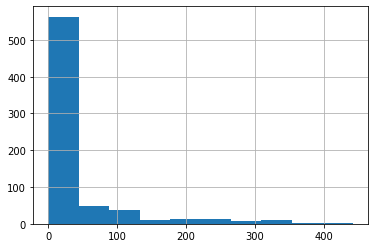

In [10]:
df2['MIC'].hist()

In [11]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

In [12]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


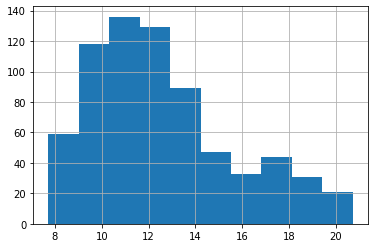

In [13]:
df2['pIC50'].hist()

In [14]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [15]:
dipep_freq = reduce_by_kmer_frequency(df2, kmer=2)

In [16]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1175.91sequence/s]


In [17]:
physicochemical_prop = get_physicochemical_properties(df2)

In [18]:
from scipy.stats import pearsonr, spearmanr

In [19]:
high_corr_dipep = []
for dipep in dipep_freq.columns:
    p_corr = pearsonr(dipep_freq[dipep], df2['MIC'])
    if p_corr[0] > 0.2:
        high_corr_dipep.append(dipep)
        #print(dipep, pearsonr(dipep_freq[dipep], df2['MIC']))

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [21]:
X = pd.concat([dipep_freq[high_corr_dipep], physicochemical_prop[['turn']]], axis=1)

In [22]:
y = df2[['pIC50', 'MIC']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [38]:
svr = SVR(C=100, gamma=1)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

[-17.43045019 -16.78346433 -18.04897181 -17.46526102 -17.28436271] -17.40250201135652
2.7423101563508783 1.1991885829214912


In [39]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [40]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [41]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [42]:
gg = list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

In [43]:
sorted(gg, key=lambda x:x[5])

[(12.8562, 12.8148, 0.32137298578846685, 2.61, 2.7201, 4.218161871248798),
 (11.2506, 11.3261, 0.6716995984518959, 13.0, 12.0538, 7.278515304548213),
 (12.075, 11.9949, 0.664064042591746, 5.7, 6.1759, 8.348860801199852),
 (13.1124, 13.2062, 0.7153655900783781, 2.02, 1.8391, 8.953670256185452),
 (11.6183, 11.724, 0.909481082117398, 9.0, 8.0975, 10.027499564093903),
 (10.625, 10.7497, 1.1730269186846236, 24.3, 21.4525, 11.718049588573715),
 (12.7169, 12.9019, 1.4546406155681388, 3.0, 2.4933, 16.888338850740016),
 (12.9957, 12.8148, 1.3918926144293124, 2.27, 2.7201, 19.82793060967372),
 (11.9655, 12.1873, 1.8537881257992836, 6.36, 5.0948, 19.893620257146853),
 (12.0238, 11.8359, 1.5624454365692206, 6.0, 7.24, 20.667006104991035),
 (10.7245, 11.0469, 3.006231172082183, 22.0, 15.9369, 27.55932994340262),
 (12.3339, 12.0895, 1.9813793687858947, 4.4, 5.6181, 27.683130940145173),
 (12.4292, 12.7703, 2.74382912601366, 4.0, 2.8441, 28.89670123651219),
 (12.5656, 12.9095, 2.7365003182463723, 3.49

In [44]:
ape_mic.mean()

3945.725836147928